In [2]:
!pip install torch-optimizer lion-pytorch -q

import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch_optimizer as optim_extra
from lion_pytorch import Lion

from torch.optim import SGD, Adam, AdamW, Adadelta, Adagrad, RMSprop, LBFGS, NAdam

print("✔ All packages installed and imported successfully")
print(f"Torch version: {torch.__version__}")
print(f"Optimizers available: SGD, Adam, Lion, RAdam, etc.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.3 MB/s eta 0:00:00
✔ All packages installed and imported success

In [3]:
# Set random seeds for reproducibility
np.random.seed(2025)
torch.manual_seed(2025)

# Parameters
n_samples = 100_000
n_features = 10
n_outputs = 3
noise_level = 0.05

# Generate input features with dependencies
X = np.zeros((n_samples, n_features))

# Independent features
X[:, 0] = np.random.normal(1, 2, n_samples)           # Gaussian
X[:, 2] = np.random.uniform(-3, 3, n_samples)         # Uniform
X[:, 4] = np.random.beta(2, 5, n_samples)             # Beta
X[:, 6] = np.random.gamma(2, 2, n_samples)            # Gamma
X[:, 8] = np.random.standard_t(5, n_samples)          # Student's t
X[:, 9] = np.random.logistic(0, 1, n_samples)         # Logistic

# Dependent / correlated features
X[:, 1] = 0.5 * X[:, 0] + np.random.normal(0, 0.3, n_samples)         # Correlated with X0
X[:, 3] = X[:, 2]**2 + np.random.normal(0, 0.2, n_samples)            # Nonlinear relation to X2
X[:, 5] = X[:, 4] + np.random.normal(0, 0.1, n_samples)               # Mildly correlated with X4
X[:, 7] = np.random.poisson(3, n_samples)                             # Discrete, independent

# Generate complex nonlinear outputs
Y = np.empty((n_samples, n_outputs))

# Output 1: Combination of periodic and polynomial relationships
Y[:, 0] = (
    np.sin(X[:, 0] * X[:, 1]) +
    np.log1p(np.abs(X[:, 2] + X[:, 3])) +
    0.1 * (X[:, 4] * X[:, 5])**2
)

# Output 2: Multiplicative and conditional relationships
mean_X6 = X[:, 6].mean()
Y[:, 1] = (
    np.where(X[:, 6] > mean_X6, X[:, 7] * X[:, 8], X[:, 7] + X[:, 8]) +
    np.tanh(X[:, 9])
)

# Output 3: Complex interaction terms
Y[:, 2] = (
    np.exp(-0.5 * X[:, 0]**2) +
    np.sqrt(np.abs(X[:, 1] * X[:, 2]) + 1e-8) +
    np.arctan(X[:, 3] * X[:, 4]) +
    np.where(X[:, 5] > X[:, 6], X[:, 7], X[:, 8])**3
)

# Add Gaussian noise to outputs
Y += noise_level * np.random.normal(0, 1, size=Y.shape)

# Convert to PyTorch tensors
X_tensor = torch.from_numpy(X).float()
Y_tensor = torch.from_numpy(Y).float()

# Print statistics
print("Input features summary:")
print("Mean:", np.round(X.mean(axis=0), 3))
print("Std :", np.round(X.std(axis=0), 3))

print("\nOutput features summary:")
print("Mean:", np.round(Y.mean(axis=0), 3))
print("Std :", np.round(Y.std(axis=0), 3))

# Print first 3 samples
print("\nFirst 3 samples:")
for i in range(3):
    print(f"Sample {i}:")
    print(f"Input : {np.round(X[i], 2)}")
    print(f"Output: {np.round(Y[i], 2)}\n")

Input features summary:
Mean: [ 9.930e-01  4.960e-01 -1.000e-03  3.019e+00  2.850e-01  2.850e-01
  3.997e+00  2.994e+00 -1.000e-03 -5.000e-03]
Std : [2.004 1.047 1.737 2.694 0.159 0.188 2.826 1.731 1.287 1.808]

Output features summary:
Mean: [1.385 1.772 2.547]
Std : [ 0.948  3.668 37.365]

First 3 samples:
Sample 0:
Input : [ 0.82 -0.1   2.1   4.57  0.25  0.3   5.45  5.    1.17  1.04]
Output: [1.98 6.65 3.47]

Sample 1:
Input : [ 2.47  0.75 -1.43  2.4   0.43  0.47  3.3   2.   -0.85  1.91]
Output: [1.64 2.05 1.43]

Sample 2:
Input : [-1.88 -1.25 -2.12  4.47  0.22  0.1   5.77  5.   -0.64  3.68]
Output: [ 1.87 -2.19  2.37]



In [4]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, n_outputs)
        )

    def forward(self, x):
        return self.layers(x)

# Test initialization
test_model = NeuralNet()
test_input = torch.randn(5, 10)
print(f"Test output shape: {test_model(test_input).shape}")
print("✔ Model architecture correct")

Test output shape: torch.Size([5, 3])
✔ Model architecture correct


In [5]:
# Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create 10 model instances
models = [NeuralNet().to(device) for _ in range(10)]

# Initialize optimizers
optimizers = [
    SGD(models[0].parameters(), lr=0.01, momentum=0.9),
    Adam(models[1].parameters(), lr=0.001),
    AdamW(models[2].parameters(), lr=0.001),
    NAdam(models[3].parameters(), lr=0.001),
    optim_extra.RAdam(models[4].parameters(), lr=0.001),
    Lion(models[5].parameters(), lr=0.001),
    Adagrad(models[6].parameters(), lr=0.01),
    Adadelta(models[7].parameters(), lr=1.0),
    RMSprop(models[8].parameters(), lr=0.001),
    LBFGS(models[9].parameters(), lr=0.1, max_iter=20)
]

# Define optimizer names in sync
optim_names = [
    "SGD", "Adam", "AdamW", "NAdam", "RAdam", "Lion", "Adagrad", "Adadelta", "RMSprop", "LBFGS"
]

# Confirm initialization
print("\n✅ Optimization algorithms initialized:")
for name in optim_names:
    print(f" - {name}")

Using device: cuda

✅ Optimization algorithms initialized:
 - SGD
 - Adam
 - AdamW
 - NAdam
 - RAdam
 - Lion
 - Adagrad
 - Adadelta
 - RMSprop
 - LBFGS


In [6]:
# Set seed for reproducibility
random.seed(2025)

# Move data to device once
X_tensor = X_tensor.to(device)
Y_tensor = Y_tensor.to(device)

# Save initial model weights for reuse
base_model = NeuralNet().to(device)
initial_state_dict = copy.deepcopy(base_model.state_dict())

# Loss function
criterion = nn.MSELoss()
history = {name: {'loss': [], 'time': 0} for name in optim_names}

for model, optimizer, name in zip(models, optimizers, optim_names):
    print(f"\n🔄 Training {name}...")

    # Reset model weights
    model.load_state_dict(copy.deepcopy(initial_state_dict))
    model.train()

    start_time = time.time()
    best_loss = float('inf')
    patience = 20
    epochs_no_improve = 0

    for epoch in range(10000):  # Early stopping will break earlier
        if name == "LBFGS":
            def closure():
                optimizer.zero_grad()
                outputs = model(X_tensor)
                loss = criterion(outputs, Y_tensor)
                loss.backward()
                return loss

            loss = optimizer.step(closure)
            with torch.no_grad():
                outputs = model(X_tensor)
                loss = criterion(outputs, Y_tensor)
        else:
            optimizer.zero_grad()
            outputs = model(X_tensor)
            loss = criterion(outputs, Y_tensor)
            loss.backward()
            optimizer.step()

        loss_value = loss.item()
        history[name]['loss'].append(loss_value)

        # Early stopping
        if loss_value < best_loss - 1e-8:
            best_loss = loss_value
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"⏹ Early stopping at epoch {epoch}")
                break

    elapsed = time.time() - start_time
    history[name]['time'] = elapsed
    print(f"{name}: Final loss = {loss_value:.6f}, Time = {elapsed:.2f}s")

print("\n✅ Fair comparison completed for all optimizers")


🔄 Training SGD...
⏹ Early stopping at epoch 121
SGD: Final loss = 468.560852, Time = 1.04s

🔄 Training Adam...
⏹ Early stopping at epoch 4818
Adam: Final loss = 24.250019, Time = 18.70s

🔄 Training AdamW...
⏹ Early stopping at epoch 4706
AdamW: Final loss = 25.641884, Time = 18.34s

🔄 Training NAdam...
⏹ Early stopping at epoch 6224
NAdam: Final loss = 22.977461, Time = 24.65s

🔄 Training RAdam...
⏹ Early stopping at epoch 4780
RAdam: Final loss = 32.626301, Time = 19.40s

🔄 Training Lion...
⏹ Early stopping at epoch 6910
Lion: Final loss = 25.506121, Time = 28.13s

🔄 Training Adagrad...
Adagrad: Final loss = 79.343956, Time = 40.08s

🔄 Training Adadelta...
⏹ Early stopping at epoch 374
Adadelta: Final loss = 82.419624, Time = 1.49s

🔄 Training RMSprop...
⏹ Early stopping at epoch 4540
RMSprop: Final loss = 22.995964, Time = 18.12s

🔄 Training LBFGS...
⏹ Early stopping at epoch 882
LBFGS: Final loss = 7.116870, Time = 269.49s

✅ Fair comparison completed for all optimizers


In [28]:
# Exclude SGD
optim_names = ["Adam", "AdamW", "NAdam", "RAdam", "Lion", "Adagrad", "Adadelta", "RMSprop"]
optim_names

['Adam', 'AdamW', 'NAdam', 'RAdam', 'Lion', 'Adagrad', 'Adadelta', 'RMSprop']

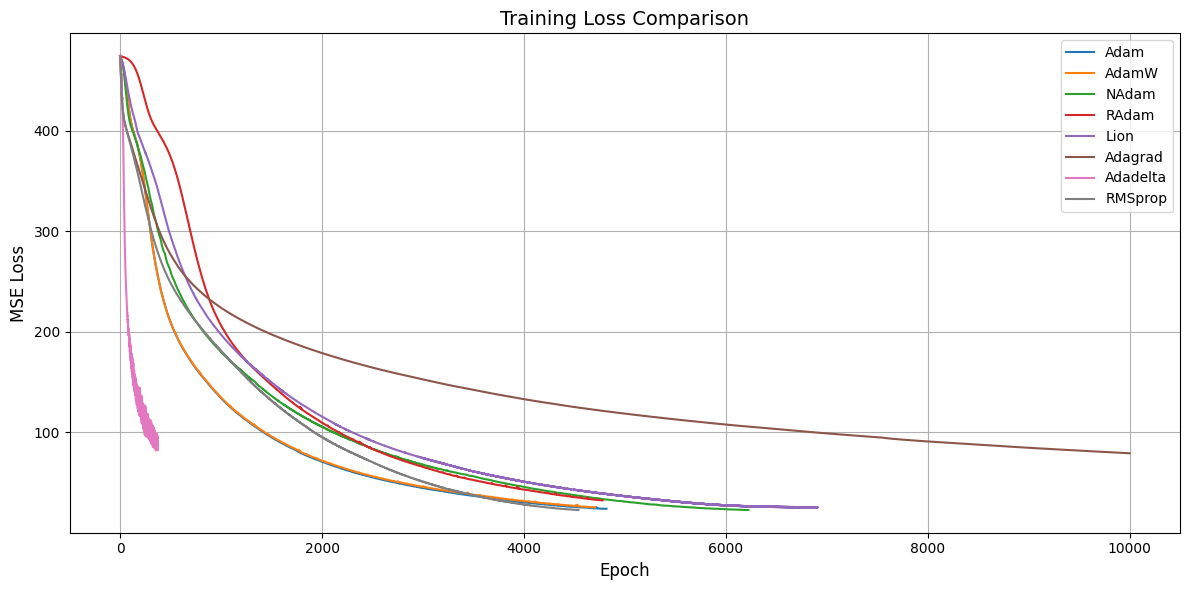

In [29]:
plt.figure(figsize=(12, 6))

# Align all loss curves to the same length (max epoch length)
max_epochs = max(len(history[name]['loss']) for name in optim_names)

for name in optim_names:
    losses = history[name]['loss']
    if len(losses) < max_epochs:
        # Pad with NaNs for alignment
        losses = losses + [float('nan')] * (max_epochs - len(losses))
    plt.plot(losses, label=name)

plt.title("Training Loss Comparison", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("MSE Loss", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

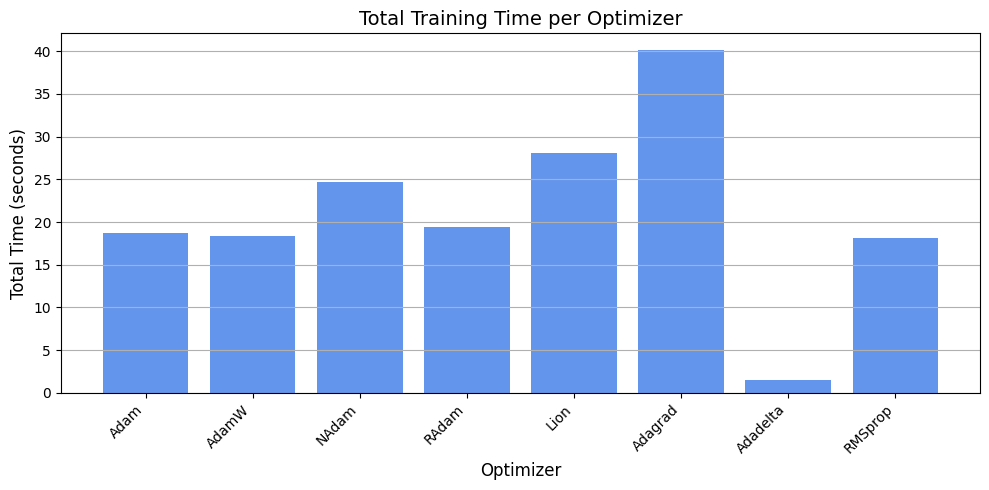

In [30]:
# Training time comparison
plt.figure(figsize=(10, 5))

times = [history[name]['time'] for name in optim_names]
plt.bar(optim_names, times, color="cornflowerblue")

plt.title("Total Training Time per Optimizer", fontsize=14)
plt.xlabel("Optimizer", fontsize=12)
plt.ylabel("Total Time (seconds)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

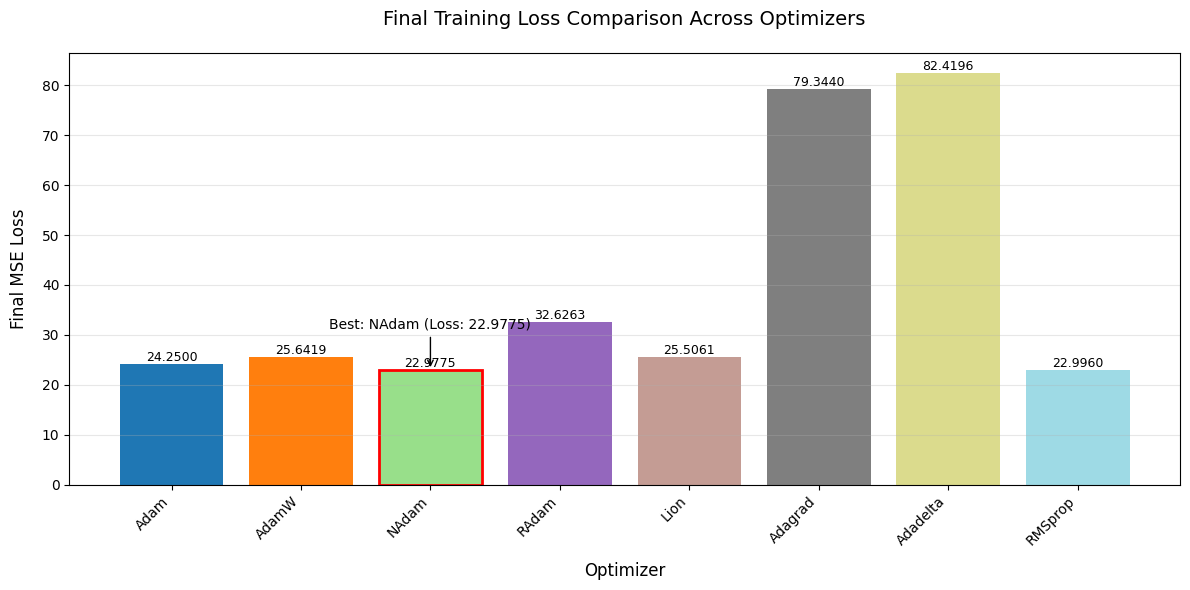

In [32]:
# Final losses
final_losses = [history[name]['loss'][-1] if history[name]['loss'] else float('inf') for name in optim_names]

# Create figure
plt.figure(figsize=(12, 6))

# Colors (better perceptual separation)
colors = plt.cm.tab20(np.linspace(0, 1, len(optim_names)))

# Bar chart
bars = plt.bar(optim_names, final_losses, color=colors)

# Value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=9)

# Axis labels and grid
plt.title('Final Training Loss Comparison Across Optimizers', pad=20, fontsize=14)
plt.xlabel('Optimizer', labelpad=10, fontsize=12)
plt.ylabel('Final MSE Loss', labelpad=10, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Highlight best performer
best_idx = int(np.argmin(final_losses))
bars[best_idx].set_edgecolor('red')
bars[best_idx].set_linewidth(2)

# Add annotation
plt.annotate(
    f'Best: {optim_names[best_idx]} (Loss: {final_losses[best_idx]:.4f})',
    xy=(best_idx, final_losses[best_idx]),
    xytext=(best_idx, final_losses[best_idx] + 0.1 * max(final_losses)),
    arrowprops=dict(facecolor='red', arrowstyle='->'),
    ha='center',
    fontsize=10
)

plt.tight_layout()
plt.show()

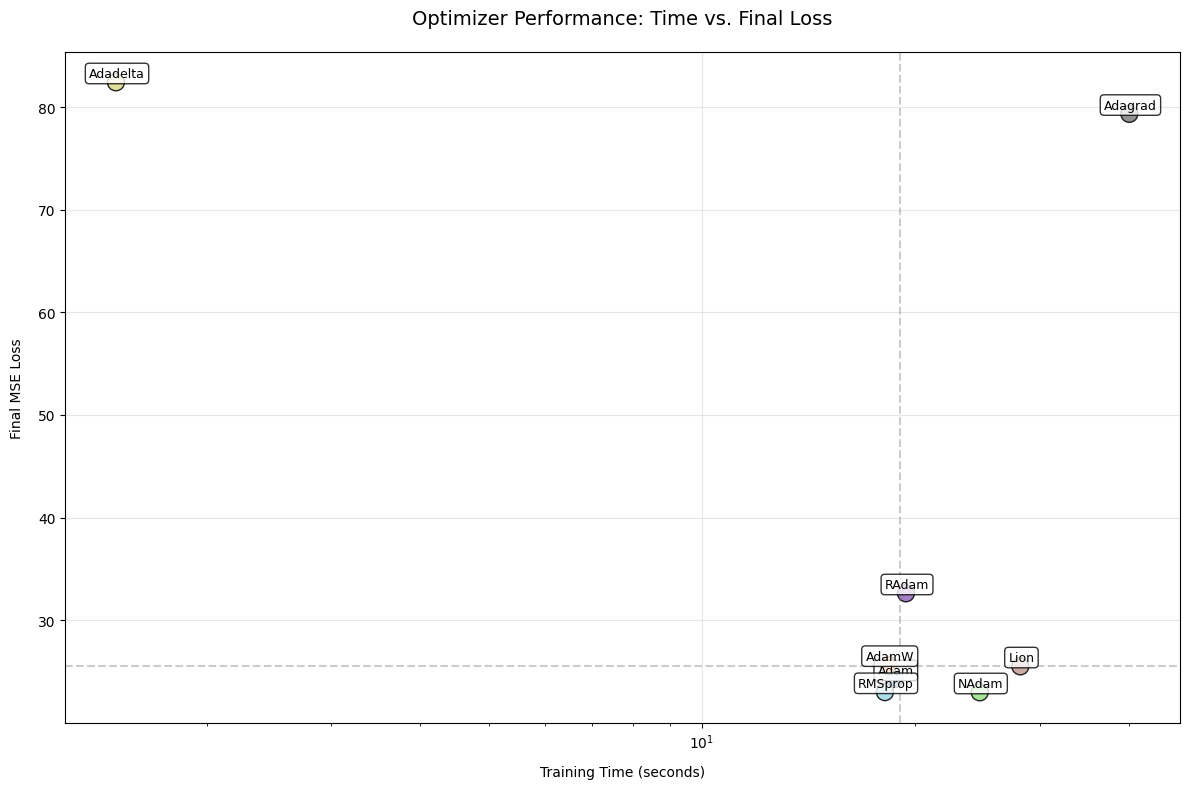

In [34]:
# Extract metrics
times = [history[name]['time'] for name in optim_names]
losses = [history[name]['loss'][-1] if history[name]['loss'] else float('inf') for name in optim_names]

# Replace zero times to avoid log scale issues
epsilon = 1e-4
times = [t if t > 0 else epsilon for t in times]

# Create figure
plt.figure(figsize=(12, 8))

# Scatter plot
colors = plt.cm.tab20(np.linspace(0, 1, len(optim_names)))
scatter = plt.scatter(times, losses, s=150, c=colors, alpha=0.85, linewidths=1, edgecolors='black')

# Annotate each point
for i, (x, y, name) in enumerate(zip(times, losses, optim_names)):
    dx, dy = 0.02 * max(times), 0.02 * max(losses)
    if name == 'LBFGS':  # Adjust for outlier
        dx, dy = -0.05 * max(times), 0
    plt.annotate(name, xy=(x, y), xytext=(dx, dy), textcoords='offset points',
                 ha='center', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8), fontsize=9)

# Reference medians
plt.axhline(np.median(losses), color='gray', linestyle='--', alpha=0.4)
plt.axvline(np.median(times), color='gray', linestyle='--', alpha=0.4)

# Titles and labels
plt.title('Optimizer Performance: Time vs. Final Loss', pad=20, fontsize=14)
plt.xlabel('Training Time (seconds)', labelpad=10)
plt.ylabel('Final MSE Loss', labelpad=10)
plt.xscale('log')
plt.grid(True, alpha=0.3)

# Quadrant labels
# plt.text(0.03, 0.05, 'Fast & Accurate', transform=plt.gca().transAxes,
#          fontsize=11, bbox=dict(facecolor='green', alpha=0.1))
# plt.text(0.60, 0.05, 'Slow but Accurate', transform=plt.gca().transAxes,
#          fontsize=11, bbox=dict(facecolor='blue', alpha=0.1))
# plt.text(0.60, 0.80, 'Slow & Inaccurate', transform=plt.gca().transAxes,
#          fontsize=11, bbox=dict(facecolor='red', alpha=0.1))

# Legend alternative
plt.tight_layout()
plt.show()